# mdxplain Quickstart Tutorial: Introduction to Conformational Analysis with mdxplain


![mdxplain Results figure](images/mdxplain_results.png)

Attention: This notebook shows a quick example. The same notebook in much more detail can be checked at [Full Notebook](02_VillinHeadpiece_Full_Analysis.ipynb)

This figure shows the visualized analysis of a Villin Headpiece simulation. How one can split the conformational ensemble in different states and what are the characteristic contacts / interactions in this states to distinguish them from all other states.

Free-energy landscape with cluster centers and densities show how the conformational ensemble is distributed and clustered. Cluster membership timelines show which frame is attached to which cluster and the time evolution.
Decision-tree plots show the rules which can be used to distinguish a cluster from all other frames. 
Violin plots show how found discriminative features distributes in the frames of different clusters.
Time-series plots show their behavior over time and at cluster changes. 
3D visulaization help to map these features onto the 3D structure to make biological interpretation easier. 

Every panel is generated by mdxplain and then arranged into the figure with Inkscape. mdxplain handles everything for you. From data loading, over clustering and ML to visualization.

Deep dives like this usually take lots of custom scripts. Here the core workflow is 19 mdxplain lines. Execute the cells top-to-bottom to regenerate the outputs. When you want the figure assets, set `save_fig=True` (plus `file_format="svg"`) on the plotting calls; then combine the saved panels in Inkscape. 

Import the `PipelineManager`, the single entry point that wires together all methods of mdxplain. All pipeline configuration happens through its submodules.

In [1]:
from mdxplain import PipelineManager

Initialize the pipeline with memory mapping for large trajectories (tweak `chunk_size` if you have more RAM). Load the Villin Headpiece trajectory (`../data/2RJY/`) and tag each frame with basic labels for downstream selectors.

In [2]:
# Initialize pipeline and load trajectory data
pipeline = PipelineManager(use_memmap=True, chunk_size=1000, show_progress=False)

pipeline.trajectory.load_trajectories("../data/2RJY/")
pipeline.trajectory.add_labels(
        traj_selection="all"
    )

📦 Creating Zarr cache: ./cache/simulation_run1.dask.zarr
  🔍 Analyzing trajectory dimensions...
  📐 Trajectory: 10001 frames × 1027 atoms
  💾 Writing trajectory data...
  ✅ Cache created: ./cache/simulation_run1.dask.zarr
  📊 Size: 89.0 MB

Loaded 1 systems with 1 total trajectories:
  2RJY: 1 trajectories


Feature engineering: compute residue-residue distances and a contact map at a 4.5 Angstrom cutoff. Build the `contacts_only` selector and activate it so downstream steps work on interaction fingerprints instead of raw coordinates.

In [3]:
pipeline.feature.add.distances()
pipeline.feature.add.contacts(cutoff=4.5)
pipeline.feature_selector.create("contacts_only")
pipeline.feature_selector.add.contacts("contacts_only", "all")
pipeline.feature_selector.select("contacts_only")

Generated 1953 residue pairs for 64 residues
Created feature selector: 'contacts_only'
Added to selector 'contacts_only': contacts -> 'all' (use_reduced=False, common_denominator=True, traj_selection=all, require_all_partners=False)
Applied feature selector 'contacts_only' with reference trajectory 0 successfully


Dimensionality reduction: contact kernel PCA projects the contact features into four components for visualization and clustering. We fix `n_components=4` (rather than auto) to keep this tiny example clean and avoid over-fragmented clusters.

In [4]:
pipeline.decomposition.add.contact_kernel_pca(
    n_components=4,
    selection_name="contacts_only", 
    decomposition_name="ContactKernelPCA",
)

Starting eigendecomposition for 4 components...
Eigendecomposition completed after 21 matrix-vector products
Decomposition 'contact_kernel_pca' with name 'ContactKernelPCA' for selection 'contacts_only' computed successfully. Data reduced from (10001, 1953) to (10001, 4).


Clustering: Density Peak (DPA) locates high-density centers without predefining the cluster count. `Z=2.5` controls separation, raise it for fewer broader states, lower it for finer granularity.

In [5]:
pipeline.clustering.add.dpa(
    "ContactKernelPCA", 
    Z=2.5,
    cluster_name="DPA_ContactKPC",
)

Clustering 'DPA_ContactKPC' completed successfully.
Found 4 clusters for 10001 frames.


Cluster membership timeline: shows how frames switch between states; long color blocks indicate stable conformations, rapid changes flag transitions or noise (black). Set `save_fig=True`/`file_format='svg'` to export.

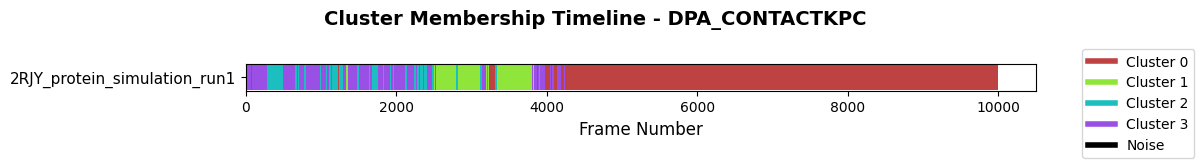

In [6]:
fig = pipeline.plots.clustering.membership(
    clustering_name="DPA_ContactKPC",
)

Free-energy landscape: Histogramm + Boltzmann inversion on kPCA components (0/1 and 2/3), colored by cluster labels.

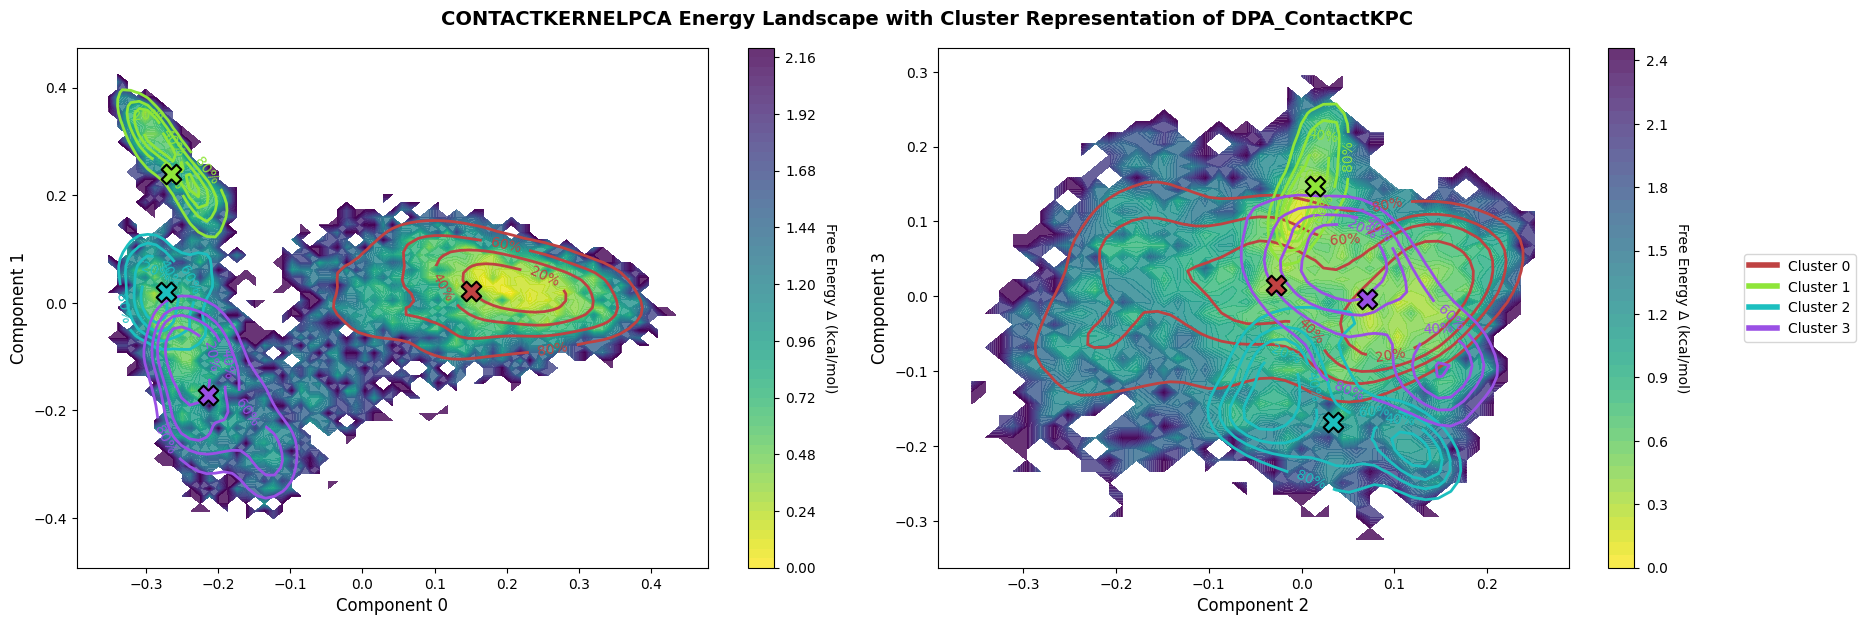

In [7]:
fig = pipeline.plots.landscape(
    decomposition_name="ContactKernelPCA",
    dimensions=[0, 1, 2, 3],
    clustering_name="DPA_ContactKPC",
)

Comparisons: build selectors per cluster and create a one-vs-rest comparison set on the contact features. This defines the targets for feature-importance models.

In [8]:
pipeline.data_selector.create_from_clusters(
    group_name="cluster",
    clustering_name="DPA_ContactKPC"
)

# Create one-vs-all comparison
pipeline.comparison.create_comparison(
    name="cluster_comparison",
    mode="one_vs_rest",
    feature_selector="contacts_only",
    data_selector_groups="cluster"
)

Feature importance model: fit decision trees to learn which contacts best separate each cluster. Trees are used for interpretability rather than generalization; they yield human-readable rules.

In [9]:
pipeline.feature_importance.add.decision_tree(
    comparison_name="cluster_comparison",
    analysis_name="feature_importance",
)

Decision tree plots: visualize per-cluster rules. Add `save_fig=True` and tweak layout parameters when exporting SVG panels for the poster.

ℹ️  depth=3 ≤ 4: Automatically using Grid mode


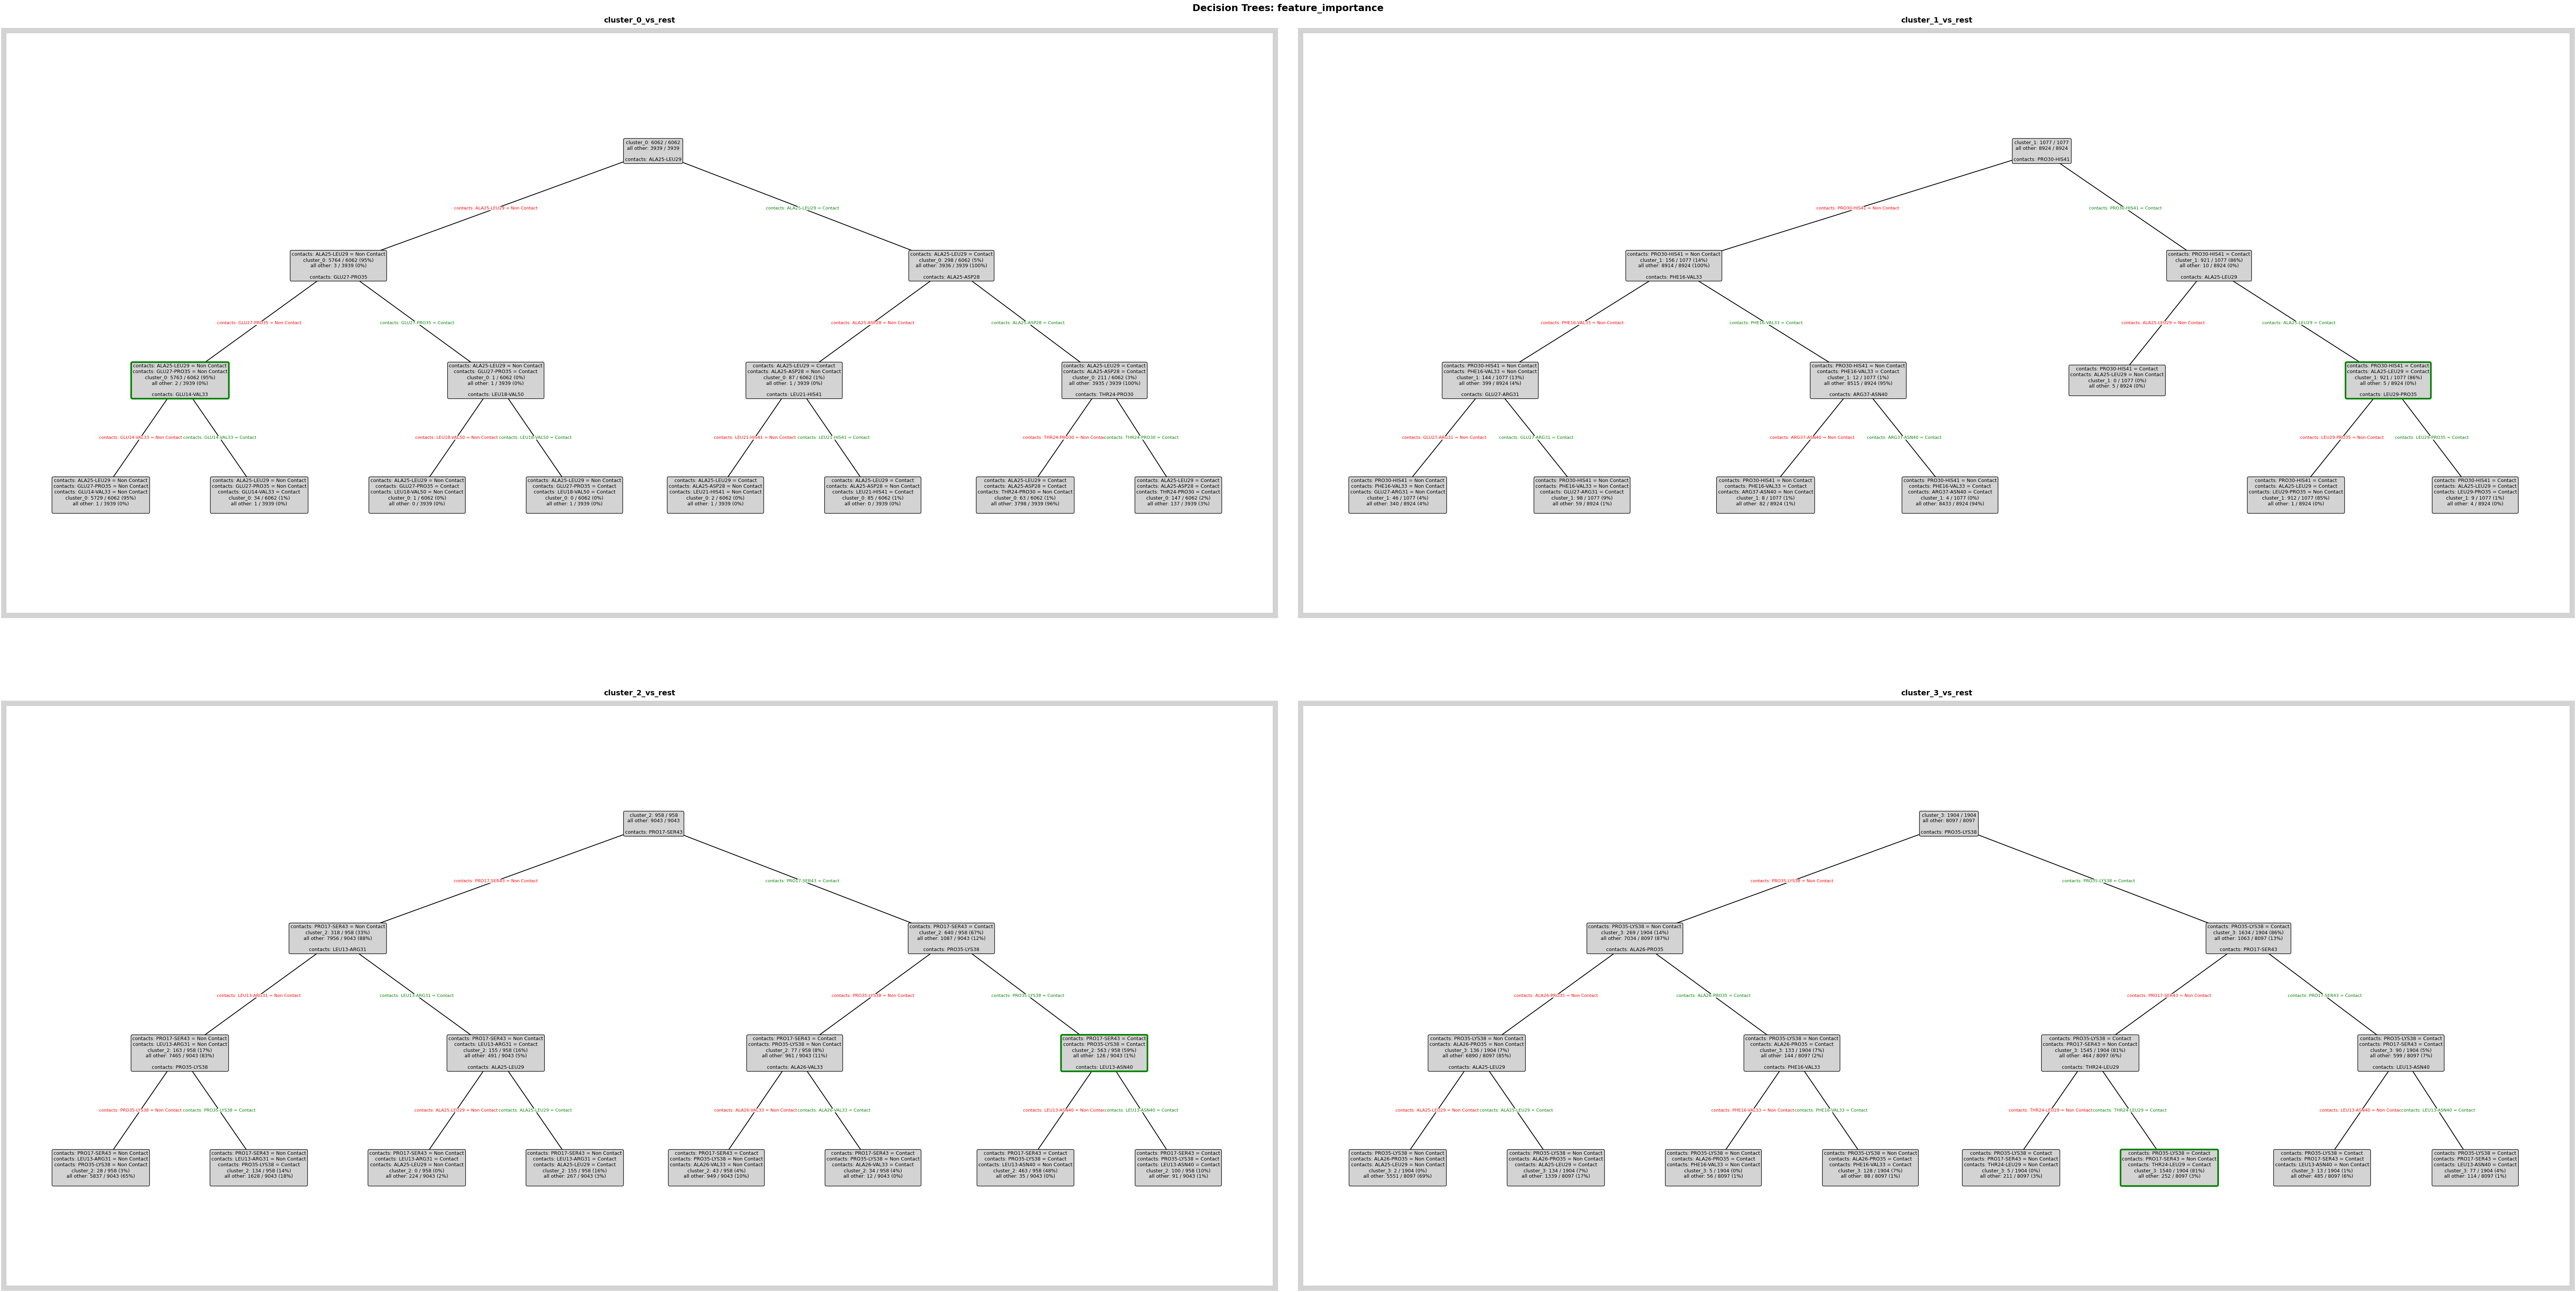

In [10]:
fig = pipeline.plots.feature_importance.decision_trees(
    feature_importance_name="feature_importance",
)

Violin plots: distributions of the top contacts across clusters to see how interaction strengths differ in different clusters. Adjust `n_top` to show more or fewer features.

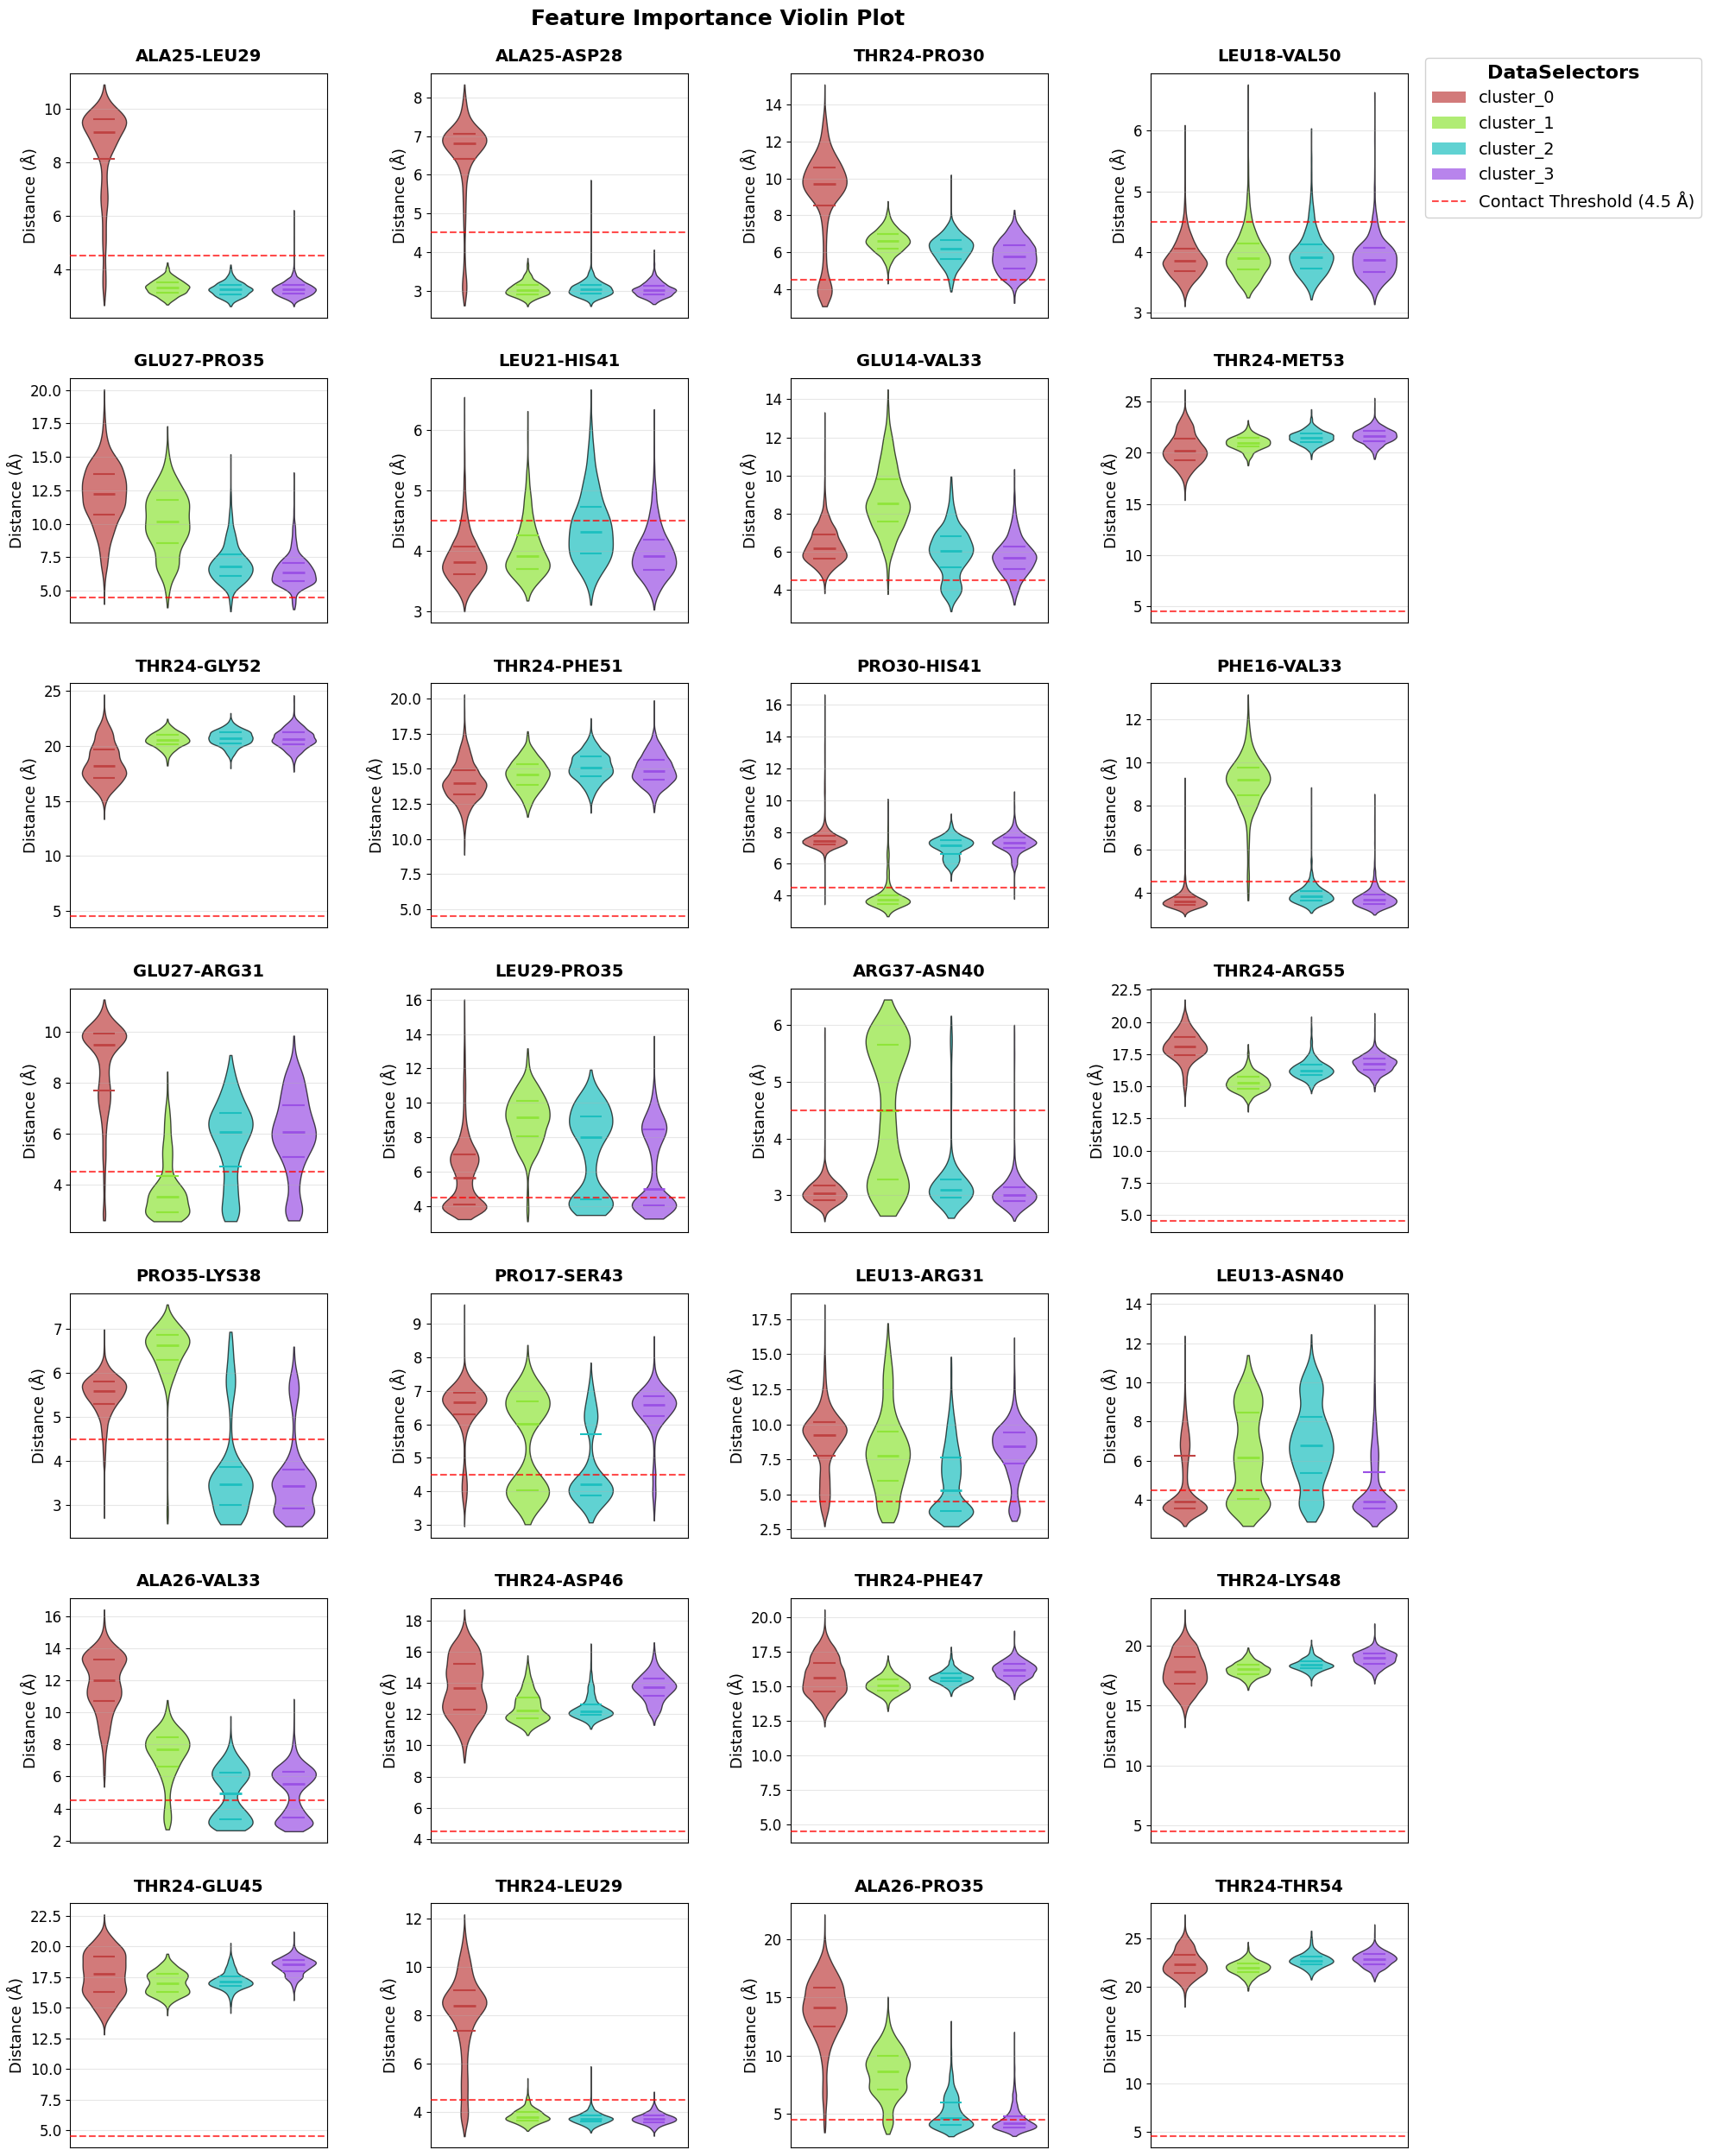

In [11]:
fig = pipeline.plots.feature_importance.violins(
    feature_importance_name="feature_importance",
)

Time series: trace the top contacts over the trajectory with cluster membership bars beneath each trace to link feature changes to state transitions.

⏱️  Loading time data...


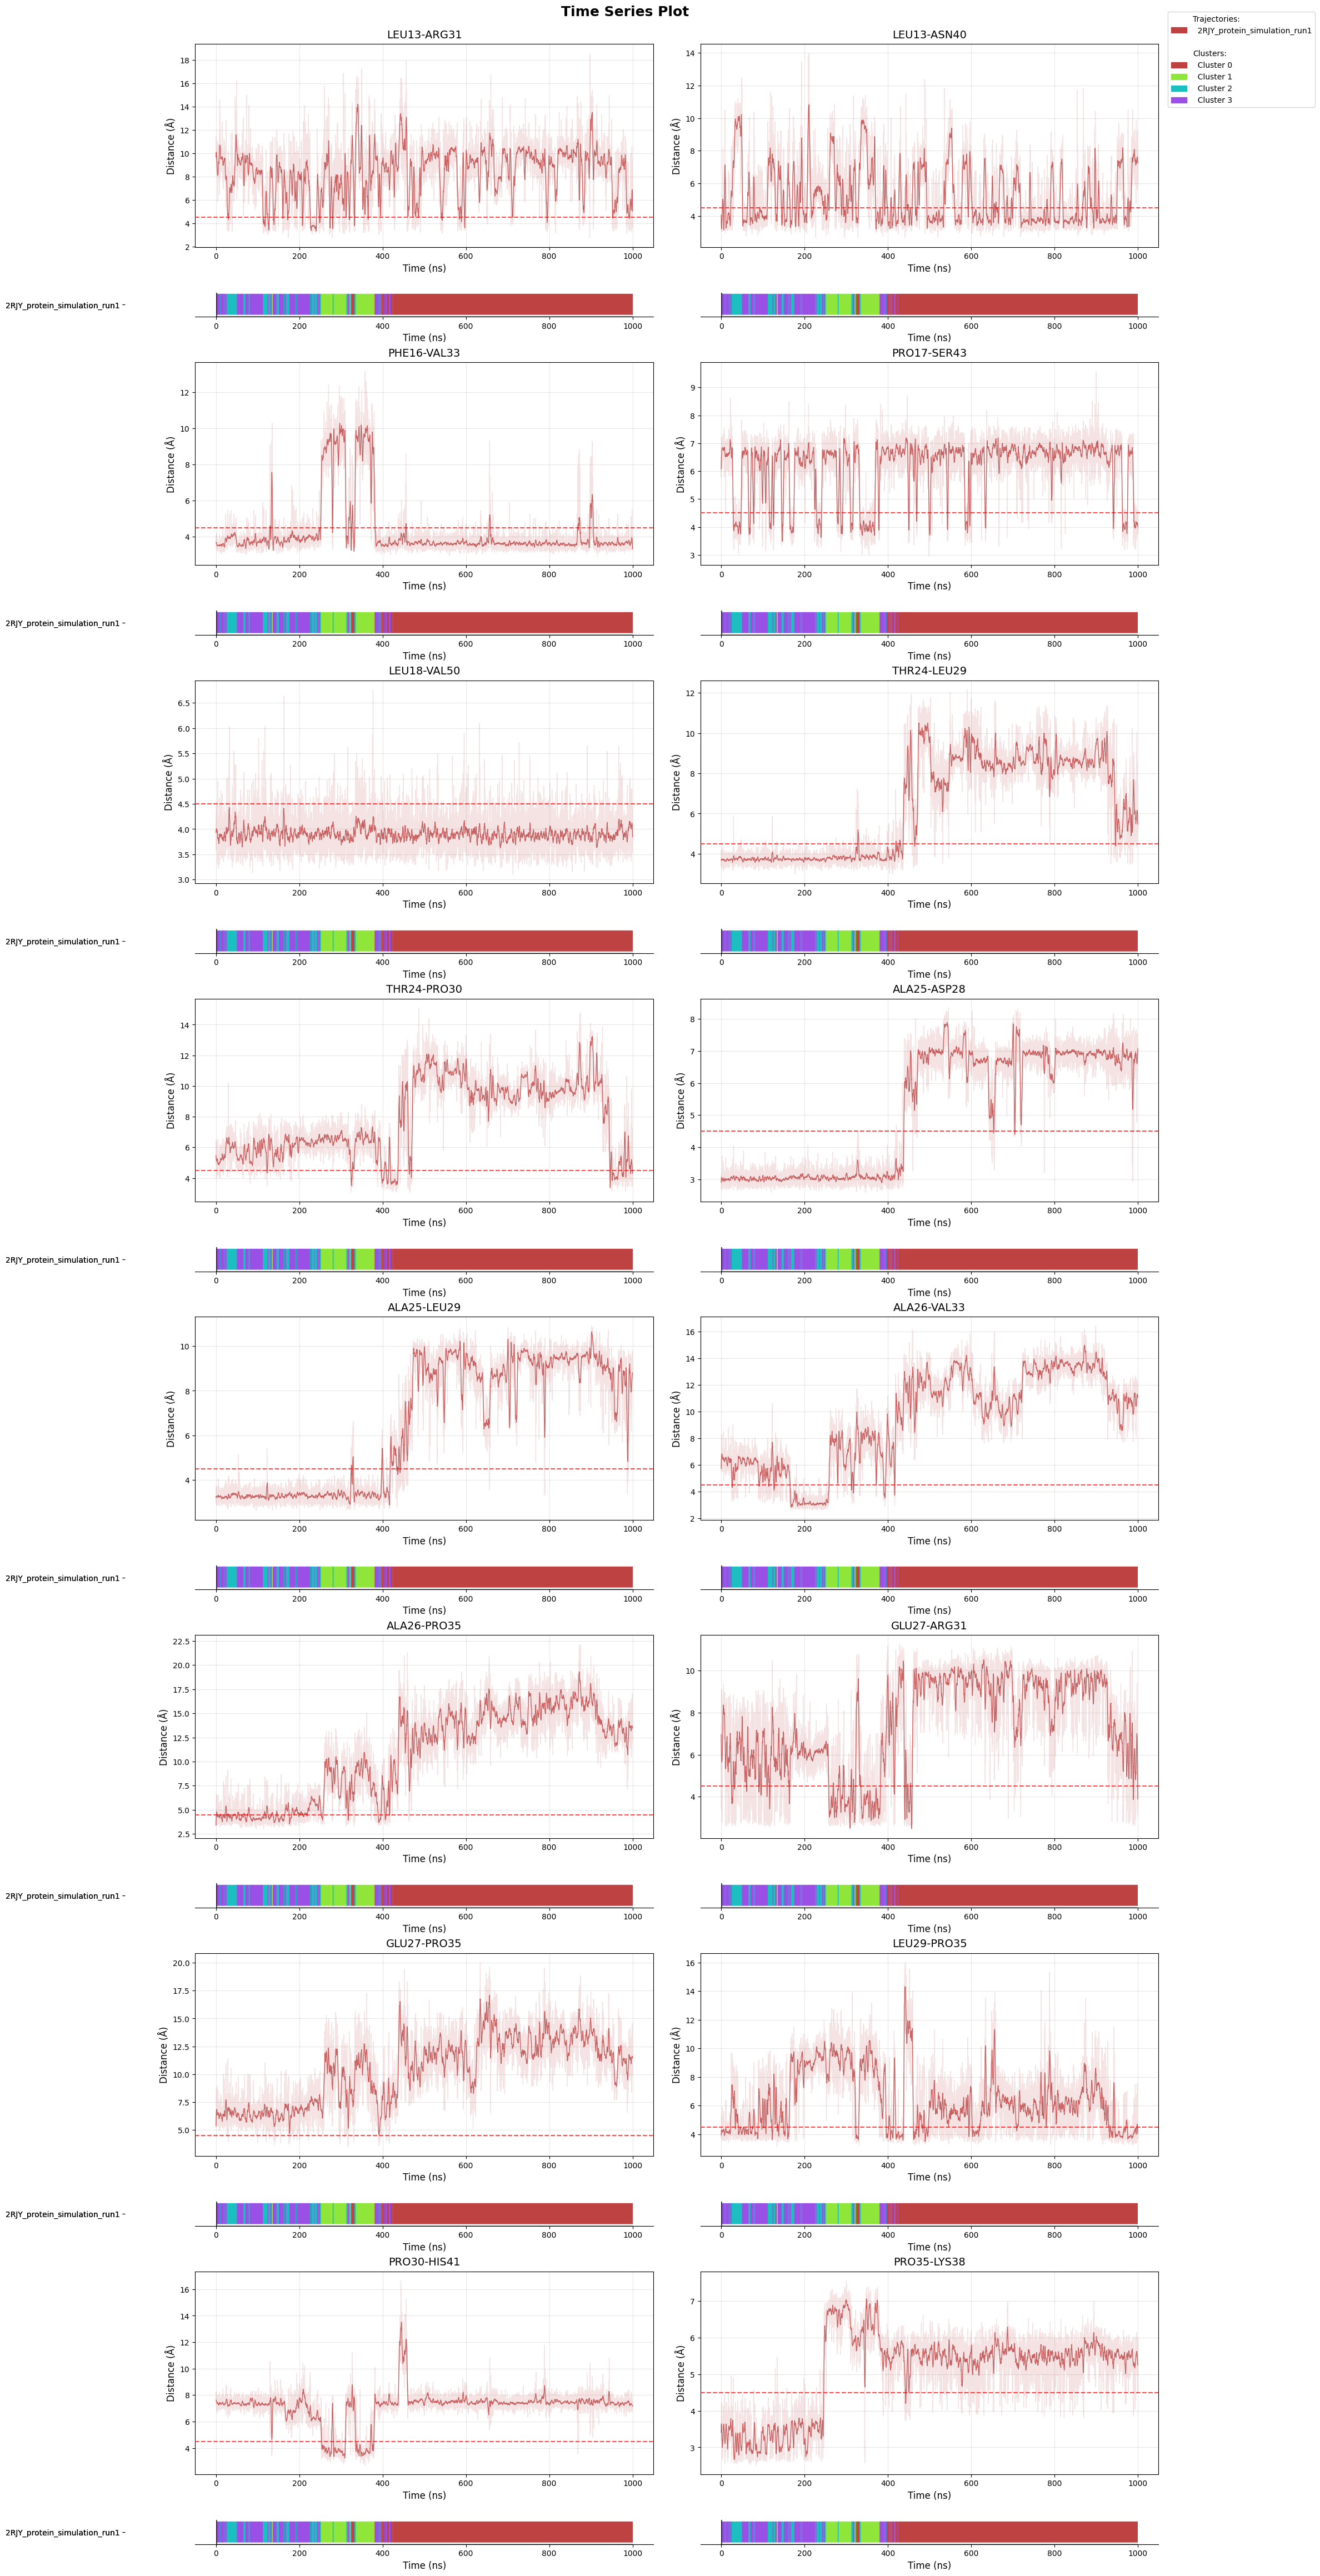

In [12]:
fig = pipeline.plots.feature_importance.time_series(
    feature_importance_name="feature_importance",
    membership_per_feature=True,
    clustering_name="DPA_ContactKPC",
)

Structure exports: write PDBs with importance encoded in B-factors and generate a PyMOL script to highlight key residues/contacts. Files land in the cache for downstream viewing.

In [13]:
pipeline.structure_visualization.feature_importance.create_pdb_with_beta_factors(
    structure_viz_name="structure_viz",
    feature_importance_name="feature_importance",
)

NGLview: open an interactive 3D view in the notebook using the exported PDBs; adjust colors and representations inside the widget.

In [14]:
ui, view = pipeline.structure_visualization.feature_importance.visualize_nglview_jupyter(
    structure_viz_name="structure_viz",
)

NGLWidget()

Archive: save the full pipeline (data, configuration, results) so you can reload or share without rerunning the analysis.

In [15]:
pipeline.create_sharable_archive("cache/example_pipeline.tar.xz")

'cache/example_pipeline.tar.xz'

Later you can reload it again and just move on with different analysis or plots.

In [16]:
loaded_pipeline_archive = PipelineManager.load_from_archive("cache/example_pipeline.tar.xz")

For a more detailed explaination of exactly this workflow check the [Full Workflow](02_VillinHeadpiece_Full_Analysis.ipynb).